TODO not fitting the intensity scale might cause problems for larger offset values

check convergence speed for large offsets. might need more epochs

In [165]:
from functools import reduce

from ptycho.misc import *

from glob import glob
import numpy as np
import dill
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# TODO compare experimental and experimental2. Think outliers need to be removed from experimental2
prefixes = ['grf', 'experimental', 'lines_nophi2']

prefixes = reduce(lambda a, b: a + b, [glob('{}/*/'.format(prefix)) for prefix in prefixes])

add = lambda a, b: a + b
params_paths = reduce(add, [glob('{}params.dill'.format(p)) for p in prefixes])
hpaths = reduce(add, [glob('{}history.dill'.format(p)) for p in prefixes])

def load_dill(path):
    print('load', path)
    with open(path, 'rb') as f:
        return dill.load(f)

params = [load_dill(p) for p in params_paths]


from ptycho import params as p

load grf/05-09-2023-01.25.24_PINN,NLL/params.dill
load grf/05-09-2023-01.21.01_overlaps/params.dill
load grf/05-09-2023-01.00.11_PINN,NLL,overlaps/params.dill
load grf/05-09-2023-01.11.20_PINN,overlaps/params.dill
load grf/05-09-2023-01.43.15_none/params.dill
load grf/05-09-2023-01.34.28_PINN/params.dill
load experimental/05-09-2023-14.33.04_PINN,overlaps/params.dill
load experimental/05-09-2023-02.32.42_none/params.dill
load experimental/05-08-2023-23.07.16_PINN/params.dill
load experimental/05-09-2023-01.55.09_PINN,NLL,overlaps/params.dill
load experimental/05-09-2023-02.12.03_overlaps/params.dill
load experimental/05-09-2023-15.37.40_PINN/params.dill
load experimental/05-09-2023-15.06.39_PINN,NLL,overlaps/params.dill
load experimental/05-08-2023-23.42.13_PINN,overlaps/params.dill
load experimental/05-09-2023-15.45.26_none/params.dill
load experimental/05-09-2023-15.28.54_PINN,NLL/params.dill
load experimental/05-16-2023-16.45.57_/params.dill
load experimental/05-08-2023-23.16.06_non

In [166]:
from ptycho import plotting as pp

In [167]:
def read_img(path):
    img = mpimg.imread(path)
    return colormap2arr(img,cm.jet)

In [168]:
keys = ['mae', 'psnr', 'frc50', 'label', 'data_source']
def dtake(d):
    return {k: d[k] for k in keys}

In [169]:
# df is a pandas DataFrame. Some information about it:
#
# -'A' and 'phi' are values of the second level of the multicolumn index. 
# -['experimental', 'grf', 'lines']  are values of teh first level of the multicolumn index.
# -'mae', 'psnr', and 'frc50' are the values of the second level of the multiindex.

# Here is the code that produces 'df' and console output that shows its contents.
# I will ask you to do some formatting and manipulations with the data.

df = pd.concat([pd.DataFrame({**dtake(pdict), **{'path': p}})
     for pdict, p in zip(params, hpaths)])

df = df[~(df.path == 'lines2/05-07-2023-19.24.14_4/history.dill')]

import pandas as pd

df = df.sort_index(ascending = False)

# # Step 1: Replace 0 and 1 in the index by 'A' and 'phi', respectively
# index_mapping = {0: 1, 1: 0}
# df.index = df.index.map(index_mapping)

index_mapping = {0: '$A$', 1: '$\phi$'}
df.index = df.index.map(index_mapping)

df = df.reset_index().groupby(['label', 'data_source', 'index']).mean()

# Round values to 2 significant figures
df = df.stack().unstack(level = [1, 2])

take_labels = ['none', 'PINN', 'overlaps', 'PINN,overlaps']
df = df.loc[take_labels]

df['lines'].iloc[:, 1] = np.nan

# # Swapping the order of '$A$' and '$\phi$'
# cols = df.columns.tolist()
# cols = [(col[0], '$A$' if col[1] == '$\phi$' else '$\phi$') for col in cols]
# df.columns = pd.MultiIndex.from_tuples(cols)

# # Reversing the order of ['experimental', 'grf', 'lines']
# df.columns = df.columns.sort_values(ascending=False)

# print(df)


/tmp/ipykernel_1946643/894822735.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lines'].iloc[:, 1] = np.nan


In [170]:
def to_latex_custom(df):
    # Identify best values
    best_mae = df.xs('mae', level=1).min()
    best_psnr = df.xs('psnr', level=1).max()
    best_frc50 = df.xs('frc50', level=1).max()
    
    latex_str = '\\begin{table}[h]\n'
    latex_str += '\\begin{center}\n'
    latex_str += '\\caption{caption }\label{tab1}%\n'
    latex_str += '\\begin{tabular}{p{2cm}l|ll|ll|ll}\n'
    latex_str += '\\toprule\n'
    latex_str += '& \\multicolumn{1}{c}{} & \\multicolumn{2}{c}{Lines} & \\multicolumn{2}{c}{GRF} & \\multicolumn{2}{c}{Large features}\\\\\n'
    latex_str += '\\midrule\n'
    latex_str += '&\n'
    latex_str += '& $\\phi$ & $A$\n'
    latex_str += '& $\\phi$ & $A$\n'
    latex_str += '& $\\phi$ & $A$ \\\\\n'
    latex_str += '\\midrule\n'
    
    order = ['none', 'PINN', 'overlaps', 'PINN,overlaps']

    for label in order:
        label_group = df.loc[label]

        if label == 'none':
            latex_str += '$\\{\\}$\\footnotemark[1]\n'
        elif label == 'PINN,overlaps':
            latex_str += 'PINN,overlaps\\footnotemark[2]\n'
        else:
            latex_str += label + '\n'

        for sublabel, row in label_group.iterrows():
            if sublabel == 'mae':
                extra = ''
            elif sublabel == 'psnr':
                extra = ' (dB)'
            else:
                extra = ' ($\mathrm{pixel}^{-1}$)'
            latex_str += '& ' + sublabel.upper() + extra + ' '

            for column, value in reversed(list(row.iteritems())):
                if pd.isnull(value):
                    latex_str += '& - '
                elif isinstance(value, float):
                    # Check if this value is the best for this metric and column
                    is_best = False
                    if sublabel == 'mae' and value == best_mae[column]:
                        is_best = True
                    elif sublabel == 'psnr' and value == best_psnr[column]:
                        is_best = True
                    elif sublabel == 'frc50' and value == best_frc50[column]:
                        is_best = True
                    
                    # Format value with rounding and potentially bolding
                    if value > 1:
                        formatted_value = '{:.1f}'.format(value)
                    else:
                        formatted_value = '{:.3g}'.format(value)

                    if is_best:
                        formatted_value = '\\textbf{' + formatted_value + '}'

                    latex_str += '& ' + formatted_value + ' '
                else:
                    latex_str += '& ' + str(value) + ' '
            
            latex_str += '\\\\\n'

        latex_str += '\\midrule\n'

    latex_str += '\\end{tabular}\n'
    latex_str += '\\end{center}\n'
    latex_str += '\\footnotetext[1]{supervised baseline}\n'
    latex_str += '\\footnotetext[2]{full PtychoPINN}\n'
    latex_str += '\\end{table}\n'
    return latex_str

print(to_latex_custom(df))


\begin{table}[h]
\begin{center}
\caption{caption }\label{tab1}%
\begin{tabular}{p{2cm}l|ll|ll|ll}
\toprule
& \multicolumn{1}{c}{} & \multicolumn{2}{c}{Lines} & \multicolumn{2}{c}{GRF} & \multicolumn{2}{c}{Large features}\\
\midrule
&
& $\phi$ & $A$
& $\phi$ & $A$
& $\phi$ & $A$ \\
\midrule
$\{\}$\footnotemark[1]
& MAE & - & 0.201 & 0.0458 & 0.0181 & 0.543 & 0.00385 \\
& PSNR (dB) & - & 59.6 & 71.9 & 80.9 & 50.7 & 92.7 \\
& FRC50 ($\mathrm{pixel}^{-1}$) & - & 22.0 & 53.0 & 56.0 & 5.0 & 33.5 \\
\midrule
PINN
& MAE & - & 0.18 & 0.11 & 0.0371 & 0.493 & 0.0114 \\
& PSNR (dB) & - & 61.0 & 65.3 & 67.0 & 51.7 & 72.8 \\
& FRC50 ($\mathrm{pixel}^{-1}$) & - & 24.0 & 6.0 & 26.0 & 9.0 & 10.2 \\
\midrule
overlaps
& MAE & - & 0.0801 & 0.0364 & 0.0166 & 0.533 & 0.00362 \\
& PSNR (dB) & - & 68.1 & 74.6 & \textbf{81.5} & 50.6 & \textbf{93.5} \\
& FRC50 ($\mathrm{pixel}^{-1}$) & - & 62.0 & 60.0 & 62.0 & 4.0 & 36.2 \\
\midrule
PINN,overlaps\footnotemark[2]
& MAE & - & \textbf{0.0528} & \textbf{0.012} & \t

In [171]:
df

data_source         experimental                   grf                  lines  \
index                        $A$     $\phi$        $A$     $\phi$         $A$   
label                                                                           
none          mae       0.003849   0.542820   0.018066   0.045818    0.201180   
              psnr     92.690003  50.654355  80.940562  71.894424   59.553296   
              frc50    33.500000   5.000000  56.000000  53.000000   22.000000   
PINN          mae       0.011439   0.492933   0.037087   0.110371    0.179505   
              psnr     72.849494  51.687594  67.006924  65.319255   60.959528   
              frc50    10.250000   9.000000  26.000000   6.000000   24.000000   
overlaps      mae       0.003623   0.533273   0.016616   0.036387    0.080122   
              psnr     93.491093  50.622165  81.530211  74.585371   68.130957   
              frc50    36.250000   4.000000  62.000000  60.000000   62.000000   
PINN,overlaps mae       0.002877   0.149630   0.005429   0.011963    0.052841   
              psnr     75.353235  60.362358  80.549394  84.531421   71.699510   
              frc50    39.250000  44.250000  94.000000  94.000000  166.000000   

data_source                 
index               $\phi$  
label                       
none          mae      NaN  
              psnr     NaN  
              frc50    NaN  
PINN          mae      NaN  
              psnr     NaN  
              frc50    NaN  
overlaps      mae      NaN  
              psnr     NaN  
              frc50    NaN  
PINN,overlaps mae      NaN  
              psnr     NaN  
              frc50    NaN

In [172]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from operator import add
from glob import glob
from dill import load as load_dill

plt.rcParams["figure.figsize"] = (10, 10)
matplotlib.rcParams['font.size'] = 12

prefix = "lines_nophi2"
# prefix = "experimental2"
top_paths = [prefix]

params_paths = reduce(add, [glob('{}params.dill'.format(p)) for p in prefixes])

def load_dill(path):
    with open(path, 'rb') as f:
        return dill.load(f)

params = [load_dill(p) for p in params_paths]


get_label = lambda path: path.split('/')[-2].split('_')[-1]
get_top_path = lambda path: path.split('/')[0]

dpaths = reduce(add, [glob('{}recon.dill'.format(p)) for p in prefixes])
arrdict = {get_label(p): load_dill(p) for p in dpaths if get_top_path(p) in top_paths}


recons = {k: {'stitched_obj_amp': v['stitched_obj_amp'],
         'stitched_obj_phase': v['stitched_obj_phase']}
         for k, v in arrdict.items()}

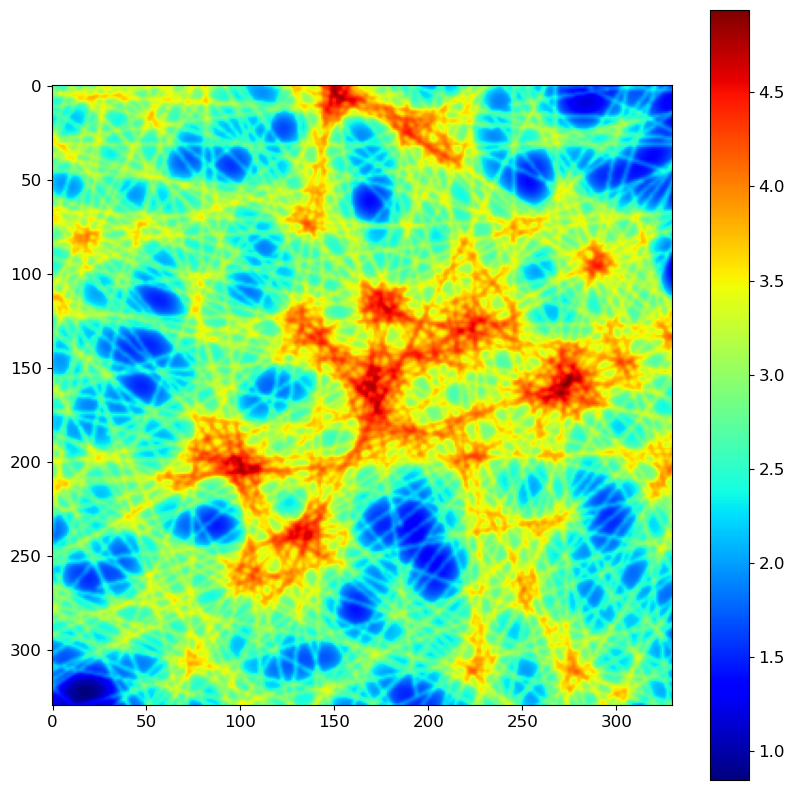

In [173]:
plt.imshow(arrdict['PINN,NLL,overlaps']['YY_ground_truth_amp'], cmap = 'jet')
plt.colorbar()

In [164]:

gt = (arrdict['PINN,NLL,overlaps']['YY_ground_truth_amp'], arrdict['PINN,NLL,overlaps']['YY_ground_truth_phi'])

# assert list(recons.keys()) == ['PINN', 'PINN,NLL,overlaps', 'none', 'PINN,NLL', 'overlaps', 'PINN,overlaps']


img_path_map = {'none': (f'images/ptychoNN_{prefix}.png', f'images/PtychoNN_phi_{prefix}.png'),
               'PINN,NLL,overlaps': (f'images/PINN_{prefix}.png', f'images/PtychoPINN_phi_{prefix}.png')}

gt_paths = (f'images/ground_truth_{prefix}.png', f'images/gt_phi_{prefix}.png')

print(img_path_map)
print(gt_paths)


def save_image(data, path, cmap='jet', add_colorbar=False, colorbar_fontsize=24):
    fig, ax = plt.subplots()
    im = ax.imshow(data, cmap=cmap)
    # Hide tick labels
    ax.set_xticks([])
    ax.set_yticks([])
    if add_colorbar:
        cbar = fig.colorbar(im, ax=ax)
        cbar.ax.tick_params(labelsize=colorbar_fontsize)
    plt.savefig(path)
    plt.close()

# Save ground truth amplitude and phase
save_image(gt[0], gt_paths[0])
save_image(gt[1], gt_paths[1], add_colorbar=True)


import zipfile
import os

# Your save_image function as provided
def save_image(data, path, cmap='jet', add_colorbar=False, colorbar_fontsize=24):
    fig, ax = plt.subplots()
    im = ax.imshow(data, cmap=cmap)
    # Hide tick labels
    ax.set_xticks([])
    ax.set_yticks([])
    if add_colorbar:
        cbar = fig.colorbar(im, ax=ax)
        cbar.ax.tick_params(labelsize=colorbar_fontsize)
    plt.savefig(path)
    plt.close()

# Function to add files to a zip archive
def add_to_zip(zipf, path):
    zipf.write(path)

# Creating the zip archive
zipf = zipfile.ZipFile('Images.zip', 'w', zipfile.ZIP_DEFLATED)

# Save ground truth amplitude and phase
save_image(gt[0], gt_paths[0])
add_to_zip(zipf, gt_paths[0])
save_image(gt[1], gt_paths[1], add_colorbar=True)
add_to_zip(zipf, gt_paths[1])

# Save reconstructions
for key in img_path_map:
    amp_path, phase_path = img_path_map[key]
    save_image(recons[key]['stitched_obj_amp'], amp_path)
    add_to_zip(zipf, amp_path)
    save_image(recons[key]['stitched_obj_phase'], phase_path, add_colorbar=True)
    add_to_zip(zipf, phase_path)

# Closing the zip archive
zipf.close()


{'none': ('images/ptychoNN_experimental2.png', 'images/PtychoNN_phi_experimental2.png'), 'PINN,NLL,overlaps': ('images/PINN_experimental2.png', 'images/PtychoPINN_phi_experimental2.png')}
('images/ground_truth_experimental2.png', 'images/gt_phi_experimental2.png')


In [ ]:


# Function to filter out outliers
def filter_outliers(group, threshold=0.5):
    numeric_cols = group.select_dtypes(include='number')
    return group[(numeric_cols < (1 + threshold) * numeric_cols.mean()).all(axis=1)]

# Apply the function to each group and aggregate by averaging
# result = grouped.apply(filter_outliers).groupby(level=[0, 1]).mean()


result = pd.DataFrame(result.stack())

result = result.unstack(1)


#df = df.groupby(level = [0, 1]).agg('mean')